In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map, tree_flatten
from jax.flatten_util import ravel_pytree

from jax import jit,vmap
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm
import gm_glm_bayesian_helper as glmh
import math_functions as mf
import plot_mcmc as pmc
reload(pmc)

<module 'plot_mcmc' from '/mnt/home/szheng/projects/util_code/plot_mcmc.py'>

In [2]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

In [3]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = [i for i in range(len(fr_['cell_cols']['pyr']))  if unit_str == fr_['cell_cols']['pyr'][i]][0]

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


2022-08-09 10:29:53.039717: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


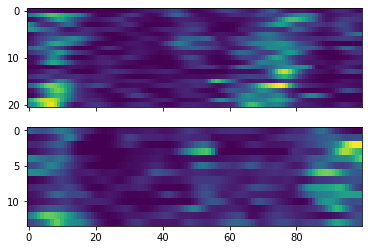

In [4]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].imshow(fr_map_[0][unit_ind_in_pyr].T,aspect='auto')
ax[1].imshow(fr_map_[1][unit_ind_in_pyr].T,aspect='auto')
# ax[1].set_xticklabels()

In [43]:
def construct_inv_mass(pars_,uncentered=True):
    '''
    scale_dict: rough range of variation each parameter can have
    block diagonal matrix, 
    each block:  the same paramter across trials have covariance given by inverse modified laplacian times the scale / 2 * (sth related to ntrials), since single trial accumulates less gradient than the trial averaged params
    otherwise, diagonal given by the scale
    in the end, divide everything by the max of these scales
    '''
#     pars_ = pars_sim_init_one
    if uncentered:
        
        nfields=pars_['mus'].shape[1]
        ntrials =pars_['delta_ws'].shape[0]
        scale_dict = {'logb_bar':2., 'delta_b':0.5, 'logsigmas':10., 'logws_bar':100.,'delta_ws':20., 'mus':200./nfields, 'ws_bar':100.}
        
    else:
        
        nfields=pars_['mus'].shape[1]
        ntrials =pars_['logws'].shape[0]
        scale_dict = {'b_bar':2., 'logb':2., 'logsigmas':10., 'logws':100., 'mus':200/nfields, 'ws_bar':100.}
    cov_base = mf.get_modified_laplacian_matrix(ntrials,inv=True)

    pars_flatten,treedef=tree_flatten(pars_)
    par_keys = sorted(pars_.keys())
    npars = len(ravel_pytree(pars_)[0])
    inv_mass_l = []
    for k,pf in zip(par_keys,pars_flatten):
        scale = scale_dict[k]
        if len(pf.shape)<=1:
            sub_inv_mass_one = np.eye(1) * scale
        else:
            ntrials,nfields=pf.shape
            nparleaf = ntrials * nfields
            if ntrials > 1:
#                 sub_inv_mass_one = np.zeros((nparleaf,nparleaf))
#                 cov_across_trials = cov_base * scale / 2  # when loss is summed
#                 for k in range(nfields):
#                     sub_inv_mass_one=sub_inv_mass_one.at[k::nfields,k::nfields].set(cov_across_trials)
                sub_inv_mass_one = np.eye(nparleaf) * scale
            else:
                sub_inv_mass_one = np.eye(nfields) * scale


        inv_mass_l.append(sub_inv_mass_one)
    inv_mass_matrix = scipy.linalg.block_diag(*inv_mass_l)
    inv_mass_matrix = inv_mass_matrix / numpy.max(list(scale_dict.values()))

    return inv_mass_matrix

# inv_mass_matrix = construct_inv_mass(pars_)

In [4]:
regressors = glm.get_regressors(fr)
target_spk = np.array(fr[unit_str].values)

In [62]:
%%time
key = jax.random.PRNGKey(1)
K=3
Nchains=1
Nsamples = 4000
pars_trans_init=glm.random_init_jax(key,regressors,nfields=K,uncentered=True)
reg_pars = gm.get_reg_pars({'g_w':10.,'g_b':10.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':10.})
key = jax.random.PRNGKey(0)
key_l = jax.random.split(key,num=Nchains)
pars_trans_init_multi=jax.vmap(glm.random_init_jax,in_axes=(0,None,None))(key_l,regressors,K)

pars_sim_init_one = glm.random_init_jax(key,regressors,K)
nparams = len(jax.flatten_util.ravel_pytree(pars_sim_init_one)[0])

inv_mass_matrix = construct_inv_mass(pars_sim_init_one)
# inv_mass_matrix = np.ones(nparams)

step_size = 1e-3#2e-3
sampler_func = blackjax.hmc
sampler_kw = {'step_size':step_size,'inv_mass_matrix':inv_mass_matrix,'num_integration_steps':30}


states,infos = glm.fit_multichain(regressors,pars_trans_init_multi,target_spk, reg_pars=reg_pars,reg_type='gaussian_logprior_laplacian' ,sampler_func=sampler_func,sampler_kw=sampler_kw,num_samples=Nsamples,rng_key_int=0)
samples = states.position
try:
    logprob=states.logprob
    logprob_grad =states.logprob_grad 
except:
    logprob=-states.potential_energy
    logprob_grad =states.potential_energy_grad


CPU times: user 1min 1s, sys: 18.2 s, total: 1min 19s
Wall time: 1min 25s


In [32]:
bin_to_lin

array([  0.99860207,   3.32867358,   5.5477893 ,   7.76690503,
         9.98602075,  12.20513647,  14.42425219,  16.64336791,
        18.86248363,  21.08159935,  23.30071508,  25.5198308 ,
        27.73894652,  29.95806224,  32.17717796,  34.39629368,
        36.6154094 ,  38.83452513,  41.05364085,  43.27275657,
        45.49187229,  47.71098801,  49.93010373,  52.14921946,
        54.36833518,  56.5874509 ,  58.80656662,  61.02568234,
        63.24479806,  65.46391378,  67.68302951,  69.90214523,
        72.12126095,  74.34037667,  76.55949239,  78.77860811,
        80.99772383,  83.21683956,  85.43595528,  87.655071  ,
        89.87418672,  92.09330244,  94.31241816,  96.53153389,
        98.75064961, 100.96976533, 103.18888105, 105.40799677,
       107.62711249, 109.84622821, 112.06534394, 114.28445966,
       116.50357538, 118.7226911 , 120.94180682, 123.16092254,
       125.38003827, 127.59915399, 129.81826971, 132.03738543,
       134.25650115, 136.47561687, 138.69473259, 140.91

In [63]:
pars_trans_one=glmh.get_one_sample(-1,samples,chain_ind=0)
pars_one = glm.pars_invtransform(pars_trans_one,regressors)

In [65]:
np.set_printoptions(precision=3,suppress=True)

In [66]:
pars_one

{'mus': DeviceArray([[ 32.974, 149.552, 173.054],
              [ 14.763,  61.44 , 164.689]], dtype=float32),
 'sigmas': DeviceArray([[15.265,  2.958,  6.052],
              [12.15 , 12.914,  2.95 ]], dtype=float32),
 'ws_bar': DeviceArray([[15.942, 25.945,  8.997],
              [11.681, 18.268, 56.108]], dtype=float32),
 'ws': DeviceArray([[13.315, 11.57 , 14.343],
              [ 0.   , 34.046, 39.582],
              [ 4.799, 12.49 ,  0.004],
              [ 0.   , 16.991, 70.16 ],
              [16.793, 27.772, 10.65 ],
              [ 6.158, 24.048, 67.463],
              [ 0.962, 43.653, 10.624],
              [ 7.519, 31.659, 61.7  ],
              [ 8.168,  7.64 , 68.618],
              [ 0.003,  1.813, 61.135],
              [ 0.005, 26.799, 58.233],
              [ 1.91 , 32.966, 11.96 ],
              [ 0.629, 42.053,  0.939],
              [16.698, 14.29 ,  5.009],
              [ 4.878, 26.987, 59.712],
              [17.258, 28.377, 24.27 ],
              [ 0.52 ,  4.089,

In [26]:
pars_one

{'mus': DeviceArray([[ 67.15722 , 174.0375  ],
              [ 27.420559, 130.6225  ]], dtype=float32),
 'sigmas': DeviceArray([[11.315146 ,  8.33711  ],
              [ 7.1242733,  2.9689631]], dtype=float32),
 'ws_bar': DeviceArray([[32.35521, 33.16379],
              [84.99529, 81.46671]], dtype=float32),
 'ws': DeviceArray([[ 34.093674,  28.052761],
              [ 65.90848 ,  95.72493 ],
              [ 38.34195 ,  39.380615],
              [ 80.13147 ,  68.80911 ],
              [ 22.812092,  42.429844],
              [ 83.48888 ,  81.57813 ],
              [ 36.304226,  39.218643],
              [ 66.1466  ,  71.30328 ],
              [ 73.70008 ,  96.65742 ],
              [ 90.63213 ,  85.87275 ],
              [ 67.37812 ,  87.5833  ],
              [ 13.153591,  49.419426],
              [ 24.266888,  41.923584],
              [ 48.83875 ,  21.694721],
              [ 80.660034,  70.68675 ],
              [ 35.15022 ,  32.497242],
              [100.990295,  81.15074 ],
    

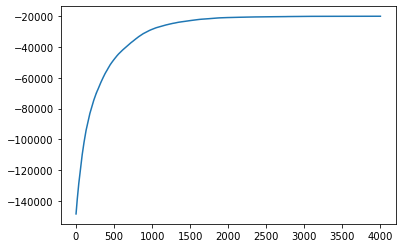

In [53]:
plt.plot(logprob)

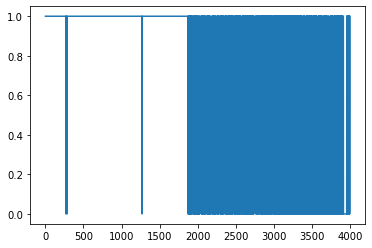

In [55]:
plt.plot(infos.is_accepted[:])

In [92]:
pars_trans_init.keys()

dict_keys(['delta_ws', 'delta_b', 'logws_bar', 'logb_bar', 'logsigmas', 'mus'])

In [115]:
pars_one['mus'][[0],:]

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

In [139]:
def split_par_trial_type(pars,regressors,type_keys = ['mus','sigmas','logsigmas','logws_bar','logb_bar'], trial_keys=['delta_ws','delta_b','ws','b']):
    pars_dict = {}
    for k,inds in regressors['trial_type_inds'].items():
        pars_dict[k] = {}
        for kk in pars.keys():
            if kk in type_keys:
                pars_dict[k][kk] = pars[kk][int(k)][None,:]
            elif kk in trial_keys:
                pars_dict[k][kk] = pars[kk][inds]
    return pars_dict

In [140]:
split_par_trial_type(pars_trans_init,regressors)[0]['mus']

DeviceArray([[  3.097,  69.764, 136.431]], dtype=float32)

{'delta_b': DeviceArray([[ 0.335],
             [ 1.403],
             [ 0.255],
             [ 0.049],
             [-1.554],
             [-0.797],
             [-1.251],
             [-1.695],
             [-1.85 ],
             [-1.086],
             [ 0.386],
             [-0.327],
             [ 1.579],
             [-2.027],
             [ 0.563],
             [-0.95 ],
             [-1.122],
             [-0.162],
             [-1.555],
             [ 0.675],
             [-0.624]], dtype=float32), 'delta_ws': DeviceArray([[ -2.627, -14.376,   5.345],
             [-11.151, -13.455, -14.572],
             [  0.851,   1.826,   1.652],
             [-15.462,  17.707,   1.627],
             [-14.192,   7.021,   2.963],
             [-16.074,  16.108,  -8.555],
             [  0.756, -11.655,  -3.995],
             [  1.316,   2.432,  15.272],
             [  4.682, -12.065,  -2.183],
             [-14.425,  -3.08 ,  19.73 ],
             [  4.191, -16.359,   6.9  ],
             [

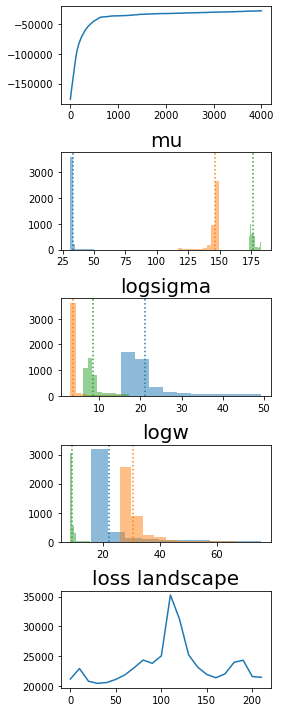

In [155]:
samples_dict = vmap(vmap(split_par_trial_type,in_axes=(0,None)),in_axes=(0,None))(samples,regressors)
samples_ = samples_dict[0]
nrows=5
ncols=1
fig = plt.figure(figsize=(ncols*4,nrows*2))

ax = fig.add_subplot(nrows,ncols,1)
ax.plot(logprob)
ax = fig.add_subplot(nrows,ncols,2)
fig,ax=pmc.plot_one_trial_one_par('mus',None,samples_,fig=fig,ax=ax)
ax.set_title('mu')
ax = fig.add_subplot(nrows,ncols,3)
fig,ax=pmc.plot_one_trial_one_par('logsigmas',None,samples_,fig=fig,ax=ax)
ax.set_title('logsigma')

ax = fig.add_subplot(nrows,ncols,4)
# fig,ax=pmc.plot_one_trial_one_par('logws',0,samples_,fig=fig,ax=ax)
fig,ax=pmc.plot_one_trial_one_par('logws_bar',None,samples_,fig=fig,ax=ax)
ax.set_title('logw')



loss_args=[regressors,pars_one,target_spk]
loss_kwargs={'reg_pars':reg_pars,'reg_type':'gaussian_logprior_laplacian'}
sample_ind=-1
pars_one = glmh.get_one_sample(sample_ind,samples_,chain_ind=0)
print(pars_one)
val_l = numpy.arange(0,220,10).astype(float)
field_ind=0
loss_l=pmc.loss_landscape_1d(pars_one,'mus',field_ind,val_l,par_arg_index=1,loss_func=glm.negative_logpdf_no_reg,loss_args=loss_args,loss_kwargs=loss_kwargs)
ax = fig.add_subplot(nrows,ncols,5)
ax.plot(val_l,loss_l)
ax.set_title('loss landscape')
plt.tight_layout()



In [124]:
samples_['mus'].shape

(4000, 1, 2, 3)

In [190]:
par_trans_one=glmh.get_one_sample(-1,samples,chain_ind=0)
par_trans_one_dict = split_par_trial_type(par_trans_one,regressors)

In [216]:
reload(glmh)
fr_map_hat = glmh.get_prediction_one(par_trans_one_dict[1],regressors,nbins=220)

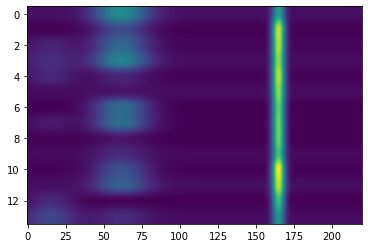

In [217]:
plt.imshow(fr_map_hat.T,aspect='auto')

In [206]:
xticks = np.arange(0,101,20)

In [211]:
xticks

DeviceArray([ 0, 20, 40, 60, 80], dtype=int32)

In [210]:
bin_to_lin[]

/tmp/ipykernel_180037/2025194880.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bin_to_lin[xticks]


IndexError: too many indices for array: array is 1-dimensional, but 5 were indexed

[Text(0, 0, '0'),
 Text(10, 0, '23'),
 Text(20, 0, '45'),
 Text(30, 0, '67'),
 Text(40, 0, '89'),
 Text(50, 0, '112'),
 Text(60, 0, '134'),
 Text(70, 0, '156'),
 Text(80, 0, '178'),
 Text(90, 0, '200'),
 Text(100, 0, '220')]

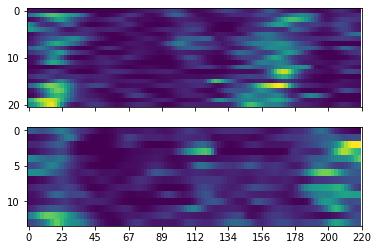

In [215]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].imshow(fr_map_[0][unit_ind_in_pyr].T,aspect='auto')
ax[1].imshow(fr_map_[1][unit_ind_in_pyr].T,aspect='auto')
xticks = np.arange(0,101,10)
xticklabels = np.array(bin_to_lin)[xticks].astype(int)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticklabels)